# EMA Trend Momentum Backtest 

### Descriptions

- Data source: [histdata.com](http://www.histdata.com) 
- Product: USD/CHF 
- Data format: a tabular time series data with 6 months 1-minute intervals, (201708 to 201801)  
- Fields: 'times', 'instrument', 'bid', 'ask', 'mid'




In [ ]:
#import libraries
import pandas as pd
import numpy as np

In [ ]:
#Instruments
instruments=['USD_CHF']

In [ ]:
##consolidate the .csv data download from histdata.com
#function of consolidation
def consolidate_bid_ask(instrument,date):
   #remember to change to your own path or read/write files
   bid = pd.read_csv('C:\\Users\\hisop\\Desktop\\MATHS&IT\\Project\\OANDA\\data\\'+instrument+"\\DAT_NT_"+instrument.replace('_','')+"_T_BID_"+date+'.csv', sep=';',header = None, names=['times','bid','instrument'])
   bid['times']=pd.to_datetime(bid['times'])
   bid['times']=bid['times'].apply(lambda x: x.replace(second=0))
   bid.drop_duplicates(subset='times', keep='first', inplace=True)   
   ask = pd.read_csv('C:\\Users\\hisop\\Desktop\\MATHS&IT\\Project\\OANDA\\data\\'+instrument+"\\DAT_NT_"+instrument.replace('_','')+"_T_ASK_"+date+'.csv', sep=';',header = None,names=['times','ask','instrument'])
   ask['times']=pd.to_datetime(ask['times'])
   ask['times']=ask['times'].apply(lambda x: x.replace(second=0))
   ask.drop_duplicates(subset='times', keep='first', inplace=True)
   data = bid.merge(ask,on=['times','instrument'],copy=False)
   #data['mid']=(data['bid']+data['ask'])/2
   data['instrument']=instrument
   data['ask']=ask['ask'].values
   data['bid']=bid['bid'].values
   return data



In [ ]:
#Consolidate the files
date=['201708','201709','201710','201711','201712','201801']
b=pd.DataFrame({'instrument':[],'times':[],'bid':[],'ask':[]})
for i in date:
    a=consolidate_bid_ask('USD_CHF',i)
    b=b.append(a[['instrument','times','bid','ask']])
    USD_CHF=b
USD_CHF.sort_values(by='times',inplace=True)
USD_CHF.to_csv('C:\\Users\\hisop\\Desktop\\MATHS&IT\\Project\\OANDA\\data\\USD_CHF\\USD_CHF.csv',index=False,header=True)

In [ ]:
#Take a look on the dataset
USD_CHF['mid']=(USD_CHF['bid']+USD_CHF['ask']) #This backtest I just used the mid price
USD_CHF.head()

In [ ]:
##Functions to calculate EMA and the backtest

def read_data(data,i): #data precrocessing
                            #Reference to my KNN_PriceReturnsPrediction_Sample.py,which has this function                             
    data_0=data
    data_0["mid"] =(data_0["bid"] + data_0["ask"])/2
    data_0.columns=["instrument","times",instruments[i]+"_bid",instruments[i]+"_ask",instruments[i]+"_mid"]
    data_0.drop('instrument', axis=1, inplace=True)
    return data_0
    
def ema(dataset,field, n,i):
    df=dataset[instruments[i]+"_"+field]
    df=pd.DataFrame(df)
    EMA =pd.ewma(df, span = n, min_periods = n - 1) 
    return EMA
def ema_diff(dataset,field, n_1,n_2,i):
    cross=ema(dataset,field,n_1,i)-ema(dataset,field,n_2,i)       
    return cross

def backtest(dataset,i):
    table=pd.DataFrame(np.zeros(shape=(dataset.shape[0],4)))
    table.columns=[["StartPrice_0","EndPrice_0","position_0","PNL_0"]]
    table['times']=dataset['times'].values
    table['mid']=dataset[instruments[i]+'_'+'mid'].values
    table['ema_diff']=ema_diff(dataset,'mid', 9,26,0).values # Parameters: short-EMA:9(mins), long-EMA:26(mins),which is
                                                             #the default setting provided by OANDA EMA indicators
    table.dropna(inplace=True)
    table.reset_index(inplace=True)
    label=0     
    for j in range(1,table.shape[0]):
        if (table.loc[j,'ema_diff']>0) & (table.shift(1).loc[j,'ema_diff']<=0):
            label=1
        elif (table.loc[j,'ema_diff']<0) & (table.shift(1).loc[j,'ema_diff']>=0):
            label=-1
        else:
            label=0               
            
        if (label == 1) & (table.loc[j-1,'position_0']==0):
            print('open + position')
            table.loc[(j+1):table.shape[0],"StartPrice_0"]=table.loc[j,'mid']
            table.loc[(j):table.shape[0],"position_0"]=1
        elif (label == -1) & (table.loc[j-1,'position_0']==0):
            print('open - position')
            table.loc[(j+1):table.shape[0],"StartPrice_0"]=table.loc[j,'mid']
            table.loc[(j):table.shape[0],"position_0"]=-1               
        elif (label == 0) & (table.loc[j-1,'position_0'] !=0) | (i==table.shape[0]):
            print('close all position')
            table.loc[(j):table.shape[0],"EndPrice_0"]=table.loc[j,'mid']
            table.loc[(j):table.shape[0],"PNL_0"]+=10000*20+10000*20*((table.loc[j,'EndPrice_0']-table.loc[j,'StartPrice_0'])/table.loc[j,'StartPrice_0'])*table.loc[j-1,"position_0"]-10000*20    
            table.loc[(j):table.shape[0],"position_0"]=0
        elif (label != table.loc[j-1,'position_0']) & (table.loc[j-1,'position_0'] != 0) & (label != 0):
            print('reverse position')
            table.loc[(j):table.shape[0],"EndPrice_0"]=table.loc[j,'mid']
            table.loc[(j):table.shape[0],"PNL_0"]+=10000*20+10000*20*((table.loc[j,'EndPrice_0']-table.loc[j,'StartPrice_0'])/table.loc[j,'StartPrice_0'])*table.loc[j-1,"position_0"]-10000*20    
            table.loc[(j+1):table.shape[0],"StartPrice_0"]=table.loc[j,'mid']
            table.loc[(j):table.shape[0],"position_0"]= label
        else:
            print('do nothing')
        print(table.shape[0]-j)    
    return table


In [ ]:
#Output
data=read_data(USD_CHF,0)
table=backtest(data,0)
table.to_csv('C:\\Users\\hisop\\Desktop\\USD_CHF.csv',index=False)

In [29]:
table=pd.read_csv('C:\\Users\\hisop\\Desktop\\USD_CHF.csv')
table.head()

,index,StartPrice_0,EndPrice_0,position_0,PNL_0,times,mid,ema_diff
0,24,0.0,0.0,0.0,0.0,2017-08-01 00:23:00,0.966835,0.000017
1,25,0.0,0.0,0.0,0.0,2017-08-01 00:24:00,0.966860,0.000021
2,26,0.0,0.0,0.0,0.0,2017-08-01 00:25:00,0.966930,0.000033
3,27,0.0,0.0,0.0,0.0,2017-08-01 00:26:00,0.966930,0.000041
4,28,0.0,0.0,0.0,0.0,2017-08-01 00:27:00,0.966875,0.000039


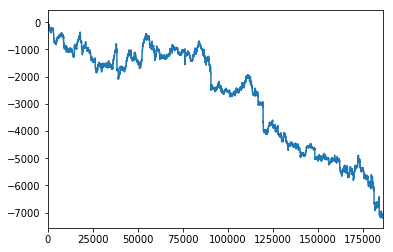

In [32]:
##PNL visualization
%matplotlib inline
table['PNL_0'].plot()


# Conclusions

- Unfoturnately the results are bad although I have not expected it has a good result.**
- The reason I did this backtest is that one day I saw the OANDA trading GUI providing the EMA indcators with fixed parameters:(9,26) so was curious to do backtest.   

## Suggestions
- Although the backtest result is not ideal, you can tune the EMA parameters or change other FX products so that the results can be improve. You can easily redo the backtest using the code above.

- I did not consider the transaction cost in this backtest. You can include it by adding the cost term  to the PNL calculation logic inside the backtest function: 
    - e.g. table.loc[(j):table.shape[0],"PNL_0"]+=10000*20+10000*20*((table.loc[j,'EndPrice_0']-t
       able.loc[j,'StartPrice_0'])/table.loc[j,'StartPrice_0'])*table.loc[j-1,"position_0"]-__cost__-10000*20
       